# Compile ISG LVs for mediation analysis

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-08-20 14:07:52.495095
Simons Foundation, Rusty HPC, worker3000


In [2]:
%cd /mnt/home/zzhang/ceph/jemm

/mnt/ceph/users/zzhang/jemm


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from tqdm import tqdm
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import statsmodels.formula.api as smf


In [4]:
DATA_VER = 'data-V9'
PCS_TO_INCL = '""'
USE_RE = True
WD = '%s/mediation_analysis' % DATA_VER
os.makedirs(WD, exist_ok=True)

enable_compilation = True
enable_all_genes = False
#%run ./notebook/navy_utils_sexDiff.py $DATA_VER $PCS_TO_INCL $USE_RE

In [5]:
if enable_compilation is True:
    # read in normalized gene TPM
    if DATA_VER == "data-V9":
        tpm_df = pd.read_table('./data-V9/charm_normalizedcounts_v9_kallisto_finalinclusion.txt', sep="\t", index_col=0)
        plier_df = pd.read_csv('./data/PLIER_v8.B.tsv', sep="\t")
        plier_df.rename(columns={x:x.split('_P')[0] for x in plier_df.columns}, inplace=True)
    else:
        raise Exception
    
    # read in ISG lvs
    isg_lvs = pd.read_csv('./data/ISG_lvsControl.T.txt', index_col=0)

    # convert ensgene to genesymbol
    import pickle
    mygenes = pd.read_table('./data/ensemblToGeneID.txt', sep="\t", index_col=0)['Gene name'].to_dict()
    add_gene = pd.read_table('./data/genename_to_ensid_map_isgs.tsv', sep="\t", index_col=0, header=None)[1].to_dict()
    mygenes.update(add_gene)
    # strip the gene version numbers
    tpm_df.index = [x.split('.')[0] for x in tpm_df.index]
    tpm_df.index = [
        mygenes[ensg] if ensg in mygenes else ensg
        for ensg in tpm_df.index
    ]
else:
    print('skipped')

In [6]:
isg_proj = pd.read_table('./data/ISG_ProjectionMatrix.txt', index_col=0).transpose()
isg_proj.rename(index={'HLA-G':'HLAG', 'HLA-E':'HLAE', 'HLA-C':'HLAC', 'HLA-F':'HLAF'}, inplace=True)
isg_proj.rename(
    columns={
        '3 CHARMcontrol': 'ISG_LV3_prj',
        '5 CHARMcontrol': 'ISG_LV5_prj',
        '6 CHARMcontrol': 'ISG_LV6_prj',
        '10 CHARMcontrol': 'ISG_LV10_prj',
    }, 
    inplace=True)
isg_proj.head()

,ISG_LV3_prj,ISG_LV5_prj,ISG_LV6_prj,ISG_LV10_prj
IFIH1,-0.000901,-0.000816,0.004179,0.007703
DDX58,0.001402,0.000202,0.002907,0.007909
IRF1,0.001310,-0.000643,0.007838,-0.004868
IRF7,-0.000360,-0.000651,0.001341,0.008734
HSH2D,0.006118,-0.000794,-0.002150,0.005193


In [7]:
a=tpm_df.loc[isg_proj.index].transpose().apply(ss.zscore)
tot_isgs_lvs = pd.DataFrame(np.matmul(a.to_numpy(), isg_proj.to_numpy()), index=a.index, columns=isg_proj.columns)
tot_isgs_lvs

,ISG_LV3_prj,ISG_LV5_prj,ISG_LV6_prj,ISG_LV10_prj
20_0149-T00,-0.270440,0.052239,-0.171728,-0.132161
20_0150-T00,-0.097068,-0.124132,-0.118177,-0.133618
20_0151-T00,-0.453541,0.128960,-0.210942,-0.061637
20_0152-T00,-0.560003,0.389627,-0.058505,-0.072572
20_0152-T28,-0.408899,0.012636,-0.183832,-0.113562
...,...,...,...,...
20_3381-T00,-0.068408,0.016921,-0.478191,-0.116673
20_3381-T07,-0.348739,0.028146,-0.153701,-0.109734
20_3381-T10,-0.432604,0.092774,-0.180053,-0.118090
20_3381-T14,-0.358612,-0.002481,-0.174159,-0.128955


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.8311123576844477, 1.059409113148809e-90)

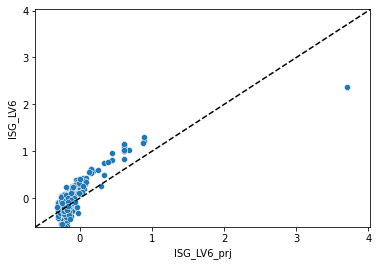

In [8]:
# check if projected values are the same as before
a = tot_isgs_lvs.join(isg_lvs)
ax = sns.scatterplot(
    a['ISG_LV6_prj'],
    a['ISG_LV6']
)
_min, _max = np.nanmin([a['ISG_LV6_prj'], a['ISG_LV6']]), np.nanmax([a['ISG_LV6_prj'], a['ISG_LV6']])
ax.set_xlim(_min, _max)
ax.set_ylim(_min, _max)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')

ss.pearsonr(a.dropna()['ISG_LV6_prj'],
    a.dropna()['ISG_LV6'])

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.9532770580990635, 5.529118440247892e-183)

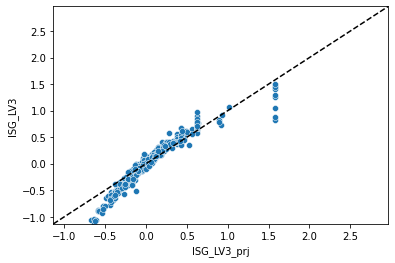

In [9]:
ax = sns.scatterplot(
    a['ISG_LV3_prj'],
    a['ISG_LV3']
)
_min, _max = np.nanmin([a['ISG_LV3_prj'], a['ISG_LV3']]), np.nanmax([a['ISG_LV3_prj'], a['ISG_LV3']])
ax.set_xlim(_min, _max)
ax.set_ylim(_min, _max)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')

ss.pearsonr(a.dropna()['ISG_LV3_prj'],
    a.dropna()['ISG_LV3'])

In [10]:
if enable_compilation is True:
    # Complete ISG genes, n=361
    IFN_GENES = pd.read_table('data/Schoggins_ISGs_tweakgenenames.20210616.fromNatalie.txt', header=None)
    # Representative ISG genes, n=33
    #IFN_GENES = pd.read_table('data/isgs_diffatcontrol_selectedbyIrene.txt', header=None)
    IFN_GENES = IFN_GENES[0].to_list()
    print(len(IFN_GENES))
    if enable_all_genes is False:
        tpm_df = tpm_df.loc[IFN_GENES]
        print(tpm_df.shape)
else:
    print('skipped')

361
(361, 1324)


In [11]:
if enable_compilation is True:
    meta = pd.read_csv('./data/charm_master.V9.tsv', index_col=0, sep="\t", low_memory=False)
    meta = meta[meta.final.isin(('Control', 'First', 'Mid'))]
    meta['sid'] = meta.index

    # add CTavg
    meta['CTavg'] = meta.apply(lambda x: x[['Nm.N.gene', 'Nm.S.gene', 'Nm.ORF1ab']].mean(), axis=1)

    # drop cols
    meta = meta[['sid', 'pid', 'tp', 'final', 'Age', 'Sex', 'CTavg', 'Symptom']]

    # add CD45 PSI
    jct_psi_df = pd.read_table('./data-V9/matrix/SE-JCT.txt', index_col=0)
    # there was a sample id/fastq filename swap between v7 -> v8/9
    # hence, I will use 20_0634-T56 to overwrite 20_0630-T56
    # zzjfrank, Aug 19, 2021
    jct_psi_df['20_0630-T56'] = jct_psi_df['20_0634-T56']
    meta['PSI_CD45RBC'] = [jct_psi_df.loc['chr1:+:198699704:198702386:198702530:198703297', sid] if sid in jct_psi_df.columns else np.nan for sid in meta.index]

    # replace asymp
    meta['Symptom'].replace({np.nan: 'asymp'}, inplace=True)


    # filter out sero-pos
    sero_pos = pd.read_table('./data-V9/merged_seropos.20210814.txt', index_col=0)
    #sero_pos['pid'] = [int(x.split('_')[1]) for x in sero_pos.iloc[:, 0]]
    print('sero pos')
    print(meta[meta.pid.isin(sero_pos.query('fz_label=="keep"').pid)][['pid','Sex']].drop_duplicates()['Sex'].value_counts())
    meta = meta[meta.pid.isin(sero_pos.query('fz_label=="keep"').pid)]
    
else:
    print('skipped')

sero pos
M    2629
F     233
Name: Sex, dtype: int64


In [12]:
if enable_compilation is True:
    # add gene TPM
    tpm_df_ = tpm_df.loc[:, meta[meta.index.isin(tpm_df)].index].transpose()
    plier_df_ = plier_df.loc[:, meta[meta.index.isin(plier_df)].index].transpose()

    isg_lvs_ = isg_lvs.loc[meta[meta.index.isin(isg_lvs.index)].index]
    tot_isgs_lvs_ = tot_isgs_lvs.loc[meta[meta.index.isin(tot_isgs_lvs.index)].index]
    
    # More molecular features can be added here.
    #meta_ = pd.concat([meta, tpm_df_, plier_df_, tot_isgs_lvs_], axis=1)
    meta_ = pd.concat([meta, tot_isgs_lvs_], axis=1)
    
    meta_ = meta_.join(isg_lvs_)
    
    # extract first and control
    infect_data = meta_.query('final=="First" or final=="Mid"')
    # compute days since infect
    infect_data['days_since_infect'] = infect_data.groupby('pid')['tp'].transform('min')
    infect_data['days_since_infect'] = infect_data['tp'] - infect_data['days_since_infect']

    infect_data.index = infect_data.pid
    ctrl_data = meta_.query('final=="Control"')

    # get number of mids missing first
    print('Mids w/o first: %i / %i' % (
        infect_data.query('final=="Mid" and days_since_infect==0').shape[0],
        infect_data.query('final=="Mid"').shape[0]
    ))
    
    print(infect_data.shape, ctrl_data.shape)
else:
    print('skipped')

Mids w/o first: 0 / 1152
(2313, 18) (10658, 17)


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
if enable_compilation is True:
    # average multiple samples for each subject if applicable
    baseline_exps = {pid: x.iloc[:, 7:].mean() for pid, x in ctrl_data.groupby('pid')}
    baseline_exps_df = pd.DataFrame.from_dict(baseline_exps).transpose()
    baseline_exps_df.rename(columns={g:'base_%s'%g for g in baseline_exps_df.columns}, inplace=True)
else:
    print('skipped')

In [14]:
baseline_exps_df.head()

,base_PSI_CD45RBC,base_ISG_LV3_prj,base_ISG_LV5_prj,base_ISG_LV6_prj,base_ISG_LV10_prj,base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_ISG_LV10
149,0.412,-0.270440,0.052239,-0.171728,-0.132161,-0.563513,0.144323,-0.089108,-0.083181
150,0.264,-0.097068,-0.124132,-0.118177,-0.133618,-0.106691,-0.136620,-0.014396,0.058888
151,0.531,-0.453541,0.128960,-0.210942,-0.061637,-0.628735,0.154666,-0.163091,0.155979
152,0.301,-0.484451,0.201131,-0.121169,-0.093067,-0.756253,0.070571,-0.205008,-0.073074
153,0.324,-0.490766,0.343728,-0.215373,-0.116855,-0.647202,0.259455,-0.414499,-0.244847


In [15]:
if enable_compilation is True:
    # only keep data with control
    #infect_data = infect_data[infect_data['pid'].isin(baseline_exps_df.index)]
    print(infect_data.shape)

    # match baseline gene exp
    infect_data = infect_data.join(baseline_exps_df)
    print(infect_data.shape)

    # keep only first with valid control values
    #infect_data = infect_data.loc[infect_data['base_IFITM1'].notna() & infect_data['CTavg'].notna()]
    infect_data = infect_data.loc[infect_data['CTavg'].notna()]
    print(infect_data.shape)
else:
    print('skipped')

(2313, 18)
(2313, 27)
(2183, 27)


In [16]:
if enable_compilation is True:
    # add delta PSI
    infect_data['delta_PSI_CD45RBC'] = infect_data['PSI_CD45RBC'] - infect_data['base_PSI_CD45RBC']
else:
    print('skipped')

In [17]:
if enable_compilation is True:
    # make a dummy variable/ one-hot encoded symptoms vector
    symp_vec = sorted(list(set([y for x in infect_data['Symptom'].unique() for y in x.split(';') if y!='other_spec' ])))
    symp_vec = {x:i for i,x in enumerate(symp_vec)}

    def symp_to_vec(symp_str, symp_vec):
        vec = np.zeros(len(symp_vec))
        n_unmatched = 0
        for s in symp_str.split(';'):
            if s in symp_vec:
                vec[symp_vec[s]] = 1
            else:
                n_unmatched += 1
        if n_unmatched > 0:
            print('unmatched symp n=%i' % n_unmatched)
        return vec

    symp_arr = []
    infect_data.index = infect_data.sid
    for sid in infect_data.index:
        symp_arr.append(symp_to_vec(infect_data.loc[sid, 'Symptom'], symp_vec))

    symp_mat = np.vstack(symp_arr)
    for symp, symp_idx in symp_vec.items():
        infect_data[symp] = symp_mat[:, symp_idx]
    
    # compute number of symps - need to remove asymp dummy variable
    infect_data['num_symps'] = np.sum(np.delete(symp_mat, symp_vec['asymp'], axis=1), axis=1)
    
    print('first ', infect_data.query('final=="First"').shape)
    print('mid ', infect_data.query('final=="Mid"').shape)
    infect_data.to_csv('%s/first_mid_data.txt'%WD, sep="\t") 
else:
    print('skipped')

unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
unmatched symp n=1
first  (1142, 44)
mid  (1041, 44)


In [18]:
if enable_compilation is True:
    # prepare for R processing
    symp_df = infect_data
    symp_df['is_female'] = [1 if x=='F' else 0 for x in symp_df['Sex']]

    TARGET_NODES = {
        'base_ISG_LVs': ['base_ISG_LV%i'%i for i in (3,5,6,10)],
        'base_ISG_LVs_prj': ['base_ISG_LV%i_prj'%i for i in (3,5,6,10)],
        'ISG_LVs_prj': ['ISG_LV%i_prj'%i for i in (3,5,6,10)],
        'CD45': ['PSI_CD45RBC', 'delta_PSI_CD45RBC'],
        'Symptom': ['asymp', 'abd', 'chill', 'cough', 'diarr', 'fatigue', 'fvr', 'headache',
                    'msk', 'nv', 'rn_nose', 'sob', 'subj_fvr', 'taste', 'throat',
                    'num_symps'
                   ],
        'CTavg': ['CTavg'],
        'covariates': ['days_since_infect']
    }


    # drop un-used cols
    cols_to_keep = [
        'sid', 'pid', 'final', 'Age', 'Sex', 'is_female',
    ] 
    #cols_to_keep += plier_df.index.to_list()
    #cols_to_keep += ['base_%s'%x for x in plier_df.index.to_list()]
    cols_to_keep += list([x for v in TARGET_NODES.values() for x in v])
    cma_df = symp_df[cols_to_keep]
    cma_df.to_csv('%s/first_mid.forCMA.txt'%WD, sep="\t", index=False)
    print(cma_df.shape)
else:
    print('skipped')

(2183, 38)


In [19]:
if enable_compilation is False:
    first_data = pd.read_csv('%s/first_mid_data.txt'%WD, sep="\t", index_col=0) 

In [20]:
mid_data = cma_df.query('final=="Mid"')
first_data = cma_df.query('final=="First"')

In [21]:
infect_data[infect_data['base_ISG_LV10_prj'].notna()].query('final=="First"').value_counts('Sex')
#cma_df[cma_df['base_ISG_LV3_prj'].notna()].query('final=="First"').value_counts('Sex')

Sex
M    193
F     25
dtype: int64

# Model Fit

In [22]:
FEATURE_GENES = [
    'ISG_LV%i'%i for i in (3,5,6,10)
]

In [23]:
first_data['base_ISG_LV3_prj']

sid
20_0149-T42   -0.270440
20_0152-T53   -0.484451
20_0155-T42   -0.673130
20_0156-T42   -0.370148
20_0157-T42   -0.127467
                 ...   
20_3468-T56         NaN
20_3471-T42         NaN
20_3472-T42         NaN
20_3474-T42         NaN
20_3475-T56         NaN
Name: base_ISG_LV3_prj, Length: 1142, dtype: float64

In [24]:
# fit a model w/o held-out
base_learner2 = LinearRegression()

data = first_data[['CTavg', 'Sex']+['base_%s'%g for g in FEATURE_GENES]].dropna()
fit_preds = base_learner2.fit(
    X=data[['base_%s'%g for g in FEATURE_GENES]], 
    y=data['CTavg']).predict(data[['base_%s'%g for g in FEATURE_GENES]])

In [25]:
norm_eff = pd.DataFrame(base_learner2.coef_ * np.array(first_data[['base_%s'%g for g in FEATURE_GENES]].mean().to_list()),
                        index=['base_%s'%g for g in FEATURE_GENES])
norm_eff

,0
base_ISG_LV3,-0.046311
base_ISG_LV5,-0.000877
base_ISG_LV6,-0.123662
base_ISG_LV10,-0.015303


Text(0.5, 0, 'Obs CT')

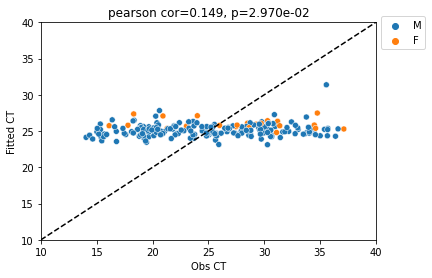

In [26]:
ax = sns.scatterplot(
    x='CTavg',
    y=fit_preds,
    hue='Sex',
    data=data
)
fg_pcc = ss.pearsonr(fit_preds, data['CTavg'])
ax.set_title(
    'pearson cor=%.3f, p=%.3e' %  fg_pcc
)
ax.set_xlim(10, 40)
ax.set_ylim(10, 40)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_ylabel('Fitted CT')
ax.set_xlabel('Obs CT')

In [27]:
def get_residual(fit_preds, first_data):
    residuals = fit_preds - first_data['CTavg']
    df = first_data.copy()
    df['res'] = residuals
    m = smf.ols('res~Sex', data=df).fit()
    return m.pvalues['Sex[T.M]']

fit_resid = get_residual(fit_preds, data)
fit_resid

0.1841590305437427

# Model Pred

In [28]:
#FEATURE_GENES = ['IFIH1', 'DDX58', 'IRF7', 'IFIT5', 'EIF2AK2', 'TRIM14', 'OASL', 'XAF1', 'USP18', 'LY6E', 'EPSTI1', 'PARP12', 'IFI44', 'IFI35', 'IFIT1', 'ISG15', 'IFI44L', 'PML', 'OAS2', 'TRIM5']
print(FEATURE_GENES)

#target = 'num_symps'
#is_classification = False
#base_learner = PoissonRegressor()
#data = first_data[first_data[target].notna()][['base_%s'%g for g in FEATURE_GENES] + [target, 'Sex']].dropna()

target = 'delta_PSI_CD45RBC'
is_classification = False
base_learner = LinearRegression() 
data = mid_data[mid_data[target].notna()]
data = data.dropna()

cv_preds = cross_val_predict(
    base_learner, 
    X=data[['base_%s'%g for g in FEATURE_GENES]], 
    y=data[target],
    cv=30 if is_classification else data.shape[0]
)

['ISG_LV3', 'ISG_LV5', 'ISG_LV6', 'ISG_LV10']


Text(0.5, 0, 'OBS')

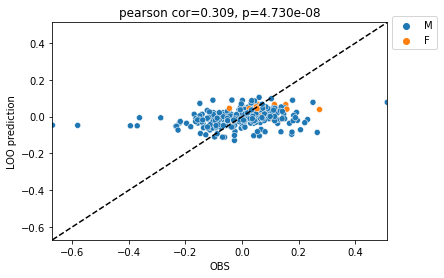

In [29]:
if is_classification:
    ax = sns.swarmplot(
        x=target,
        y=cv_preds,
        hue='Sex',
        data=data
    )
else:
    ax = sns.scatterplot(
        x=target,
        y=cv_preds,
        hue='Sex',
        data=data
    )
    ax.set_title(
        'pearson cor=%.3f, p=%.3e' % ss.pearsonr(cv_preds, data[target])
    )
    _min, _max = np.min([cv_preds, data[target]]), np.max([cv_preds, data[target]])
    ax.set_xlim(_min, _max)
    ax.set_ylim(_min, _max)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_ylabel('LOO prediction')
ax.set_xlabel('OBS')

# Misc

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying

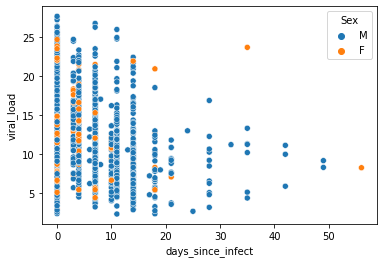

In [30]:
# extract first and control
all_infect = meta_.query('final=="First" or final=="Mid"')
# compute days since infect
all_infect['days_since_infect'] = all_infect.groupby('pid')['tp'].transform('min')
all_infect['days_since_infect'] = all_infect['tp'] - all_infect['days_since_infect']

all_infect['viral_load'] = 40 - all_infect['CTavg']
all_infect.to_csv(f'{DATA_VER}/mediation_analysis/all_infect.txt', sep="\t", index=False)

sns.scatterplot(x='days_since_infect', y='viral_load', hue='Sex', data=all_infect)

In [31]:
print("FINISH:", datetime.now())

FINISH: 2021-08-20 14:09:01.575043
